The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# IZA paper - Empirical example

Lauren Jones and Nicolas Ziebarth, "Successful Scientific Replication and Extension of Levitt (2008): Child Seats Are Still No Safer than Seat Belts", *Journal of Applied Econometrics*, Vol. 31, No. 5, 2016, pp. 920-928.

[Link to material](http://qed.econ.queensu.ca/jae/datasets/jones004/)

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from econml.dml import LinearDML, CausalForestDML

# User-written utilities - these are under src/ in the GitHub repositories 
import sys
sys.path.append('..')
import src.config as cfg
import src.features as ft
from src.dmlutils import DML_diagnostics

In [3]:
df = pd.read_csv(Path('../data/FARS-data-full-sample.txt'), sep='\t')
# The replication does not use whether child seat or belt were improperly used, and thereafter drops rows with missing values in them
df_repl = df[[feat for feat in df.columns if not feat.startswith('imp')]]
df_repl = df_repl[~df_repl.isna().max(axis=1)]
df_repl['modelyr'] = df_repl['modelyr'].astype(int)
df_repl = df_repl[df_repl['year']<=2003]
df_repl['car_age'] = df_repl['year'] - df_repl['modelyr']
print(len(df_repl))

38455


In [4]:
pipe = ft.construct_data_pipeline(pd_output=True)
cv_splitter = KFold(2, shuffle=True, random_state=cfg.random_state)

## Full sample replication with DML

In [5]:
y = df_repl['death']
T = df_repl['restraint']
W = df_repl[[col for col in df_repl.columns if col not in ['lapbelt', 'lapshould', 'childseat']]]

In [6]:
%%time
model_t = HistGradientBoostingClassifier(max_iter=100, n_iter_no_change=10, max_depth=5, early_stopping=True, random_state=cfg.random_state)
model_y = HistGradientBoostingRegressor(max_iter=100, n_iter_no_change=10, max_depth=5, early_stopping=True, random_state=cfg.random_state)
dml = LinearDML(model_t=model_t, model_y=model_y, cv=cv_splitter, discrete_treatment=True, fit_cate_intercept=True)
dml.fit(y, T.values, W=pipe.fit_transform(W))

CPU times: user 43.4 s, sys: 1.59 s, total: 45 s
Wall time: 4.01 s


In [7]:
inf = dml.intercept__inference()
inf.summary_frame()

point_estimate  stderr   zstat  pvalue  \
X              T                                                              
cate_intercept T0_1_childseat                -0.127   0.006 -20.750     0.0   
               T0_2_lap only belt            -0.109   0.007 -16.619     0.0   
               T0_3_lap/should belt          -0.149   0.007 -21.023     0.0   

                                     ci_lower  ci_upper  
X              T                                         
cate_intercept T0_1_childseat          -0.137    -0.117  
               T0_2_lap only belt      -0.120    -0.098  
               T0_3_lap/should belt    -0.160    -0.137

### Comparison with OLS benchmark

In [8]:
%%time
Tb = T.str[0].astype(int)>0
model_t = LinearRegression()
model_y = LinearRegression()
bmark = LinearDML(model_t=model_t, model_y=model_y, cv=cv_splitter, discrete_treatment=False, fit_cate_intercept=True)

bmark.fit(y, Tb.values, W=pipe.fit_transform(W))

CPU times: user 1.48 s, sys: 1.03 s, total: 2.51 s
Wall time: 303 ms


In [9]:
inf = bmark.intercept__inference()
inf.summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
cate_intercept,-0.118,0.005,-22.452,0.0,-0.127,-0.109


In [10]:
diag = DML_diagnostics(dml)
bdiag = DML_diagnostics(bmark)
pd.DataFrame([
        [r2_score(y, diag.predict_y(W=pipe.transform(W))), r2_score(T.str[0].astype(int)>0, diag.predict_T(W=pipe.transform(W)))],
        [r2_score(y, bdiag.predict_y(W=pipe.transform(W))), r2_score(Tb, bdiag.predict_T(W=pipe.transform(W)))]
    ]
    , index=['DML', 'OLS benchmark'], columns=['R2 y', 'R2 T']
)

,R2 y,R2 T
DML,0.081407,0.367481
OLS benchmark,0.060411,0.357275


## Selected sample replication (causal)

In [11]:
df = pd.read_csv(Path('../data/FARS-data-selection-sample.txt'), sep='\t')
# The replication does not use whether child seat or belt were improperly used, and thereafter drops rows with missing values in them
df_sel = df[[feat for feat in df.columns if not feat.startswith('imp')]]
df_sel = df_sel[~df_sel.isna().max(axis=1)]
df_sel['modelyr'] = df_sel['modelyr'].astype(int)
df_sel = df_sel[df_sel['year']<=2003]
df_sel['car_age'] = df_sel['year'] - df_sel['modelyr']

In [12]:
y = df_sel['death']
T = df_sel['restraint']
W = df_sel[[col for col in df_sel.columns if col not in ['lapbelt', 'lapshould', 'childseat']]]

In [13]:
%%time
model_t = HistGradientBoostingClassifier(max_iter=100, n_iter_no_change=10, max_depth=5, early_stopping=True, random_state=cfg.random_state)
model_y = HistGradientBoostingRegressor(max_iter=100, n_iter_no_change=10, max_depth=5, early_stopping=True, random_state=cfg.random_state)
dml = LinearDML(model_t=model_t, model_y=model_y, cv=cv_splitter, discrete_treatment=True, fit_cate_intercept=True)
dml.fit(y, T.values, W=pipe.fit_transform(W))

CPU times: user 16.2 s, sys: 1.22 s, total: 17.4 s
Wall time: 1.51 s


In [14]:
inf = dml.intercept__inference()
inf.summary_frame()

point_estimate  stderr  zstat  pvalue  \
X              T                                                             
cate_intercept T0_1_childseat                -0.048   0.007 -6.873     0.0   
               T0_2_lap only belt            -0.048   0.007 -6.861     0.0   
               T0_3_lap/should belt          -0.054   0.007 -7.188     0.0   

                                     ci_lower  ci_upper  
X              T                                         
cate_intercept T0_1_childseat          -0.059    -0.036  
               T0_2_lap only belt      -0.060    -0.037  
               T0_3_lap/should belt    -0.066    -0.041

### Comparison with OLS benchmark

In [15]:
%%time
Tb = T.str[0].astype(int)>0
model_t = LinearRegression()
model_y = LinearRegression()
bmark = LinearDML(model_t=model_t, model_y=model_y, cv=cv_splitter, discrete_treatment=False, fit_cate_intercept=True)

bmark.fit(y, Tb.values, W=pipe.fit_transform(W))

CPU times: user 364 ms, sys: 339 ms, total: 703 ms
Wall time: 89.1 ms


In [16]:
inf = bmark.intercept__inference()
inf.summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
cate_intercept,-0.049,0.006,-7.724,0.0,-0.06,-0.039


In [17]:
diag = DML_diagnostics(dml)
bdiag = DML_diagnostics(bmark)
pd.DataFrame([
        [r2_score(y, diag.predict_y(W=pipe.transform(W))), r2_score(T.str[0].astype(int)>0, diag.predict_T(W=pipe.transform(W)))],
        [r2_score(y, bdiag.predict_y(W=pipe.transform(W))), r2_score(Tb, bdiag.predict_T(W=pipe.transform(W)))]
    ]
    , index=['DML', 'OLS benchmark'], columns=['R2 y', 'R2 T']
)

,R2 y,R2 T
DML,0.018189,0.406288
OLS benchmark,0.021398,0.400945


## Causal forests

For simplicity, we collapse the treatment arms into havign any child protection (any of the treatment arms) or not.

In [18]:
from copy import deepcopy
feats = deepcopy(ft.feat_type)
feats['categorical'] = ['crashtm']
feats['ordinal'] = feats['ordinal'] + ['year', 'modelyr']
pipe = ft.construct_data_pipeline(feat_type=feats, pd_output=True)

In [19]:
y = df_sel['death']
T = df_sel[['childseat', 'lapbelt', 'lapshould']].max(axis=1).astype(int)
X = df_sel[[col for col in df_sel.columns if col not in ['lapbelt', 'lapshould', 'childseat']]]
X = pipe.fit_transform(W)

In [20]:
%%time
model_t = HistGradientBoostingClassifier(max_iter=100, n_iter_no_change=10, max_depth=5, early_stopping=True, random_state=cfg.random_state)
model_y = HistGradientBoostingRegressor(max_iter=100, n_iter_no_change=10, max_depth=5, early_stopping=True, random_state=cfg.random_state)
cf = CausalForestDML(model_t=model_t, model_y=model_y, cv=cv_splitter, discrete_treatment=True, random_state=cfg.random_state,
                    min_samples_split=100, min_samples_leaf=50, max_depth=3)
cf.fit(y, T.values, X=X)

CPU times: user 7.31 s, sys: 197 ms, total: 7.51 s
Wall time: 933 ms


In [21]:
cates = cf.marginal_effect(T, X=X)
print(cates.mean())

import statsmodels.api as sm
residuals = DML_diagnostics(cf).first_stage_residuals(y, T, X=X)
C = np.mean(cates)*residuals[['T']]
D = (cates - cates.mean())*residuals[['T']]
test=pd.concat([C, D], axis='columns')
test.columns = ['mean_predictions', 'differential_prediction']
test = sm.add_constant(test)
ols = sm.OLS(residuals[['y']], test)
res = ols.fit().get_robustcov_results()
res.summary()

-0.048595545227588424


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     30.52
Date:                Wed, 04 Aug 2021   Prob (F-statistic):           6.10e-14
Time:                        17:27:05   Log-Likelihood:                 2078.8
No. Observations:               10328   AIC:                            -4152.
Df Residuals:                   10325   BIC:                            -4130.
Df Model:                           2                                         
Covariance Type:                  HC1                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0005      0.002      0.279      0.780      -0.003       0.004
mean_predictions            0.9526      0.130      7.321      0.000       0.698       1.208
differential_prediction     2.9129      0.625      4.657      0.000       1.687       4.139
==============================================================================
Omnibus:                     8769.608   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           161522.015
Skew:                           4.272   Prob(JB):                         0.00
Kurtosis:                      20.388   Cond. No.                         184.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [22]:
cf.summary()

Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,-0.036,0.012,-2.971,0.003,-0.057,-0.016
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-0.045,0.023,-1.961,0.05,-0.083,-0.007
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-0.032,0.014,-2.232,0.026,-0.055,-0.008


### Characterization of CATEs

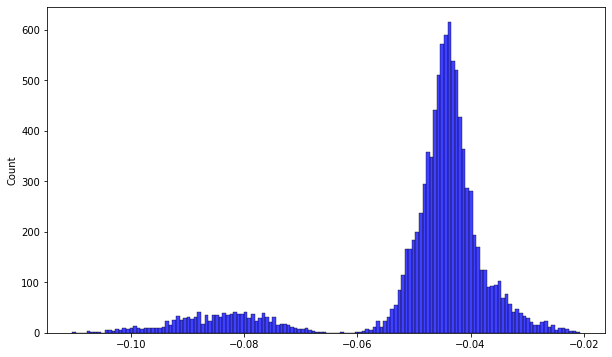

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(10, 6))

sns.histplot(x=cates[cates<0].reshape(-1), ax=ax, color='blue')
sns.histplot(x=cates[cates>0].reshape(-1), ax=ax, color='red')
plt.show() 

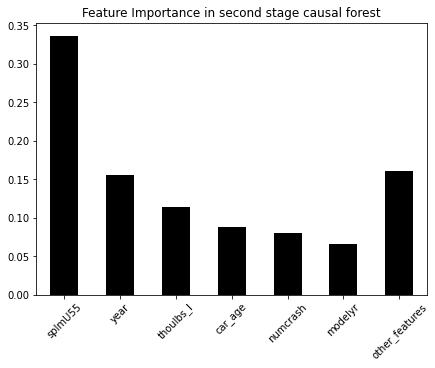

In [24]:
importances = pd.DataFrame(cf.feature_importances(), index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
importances = importances[importances['importance']>0.05]
importances = pd.concat([importances, pd.DataFrame([1 - importances.sum()], index=['other_features'], columns=['importance'])])

fig, ax = plt.subplots(1,1, figsize=(7, 5))
importances.plot(kind='bar', ax=ax, legend=None, color='black')
ax.tick_params(axis='x', rotation=45)
ax.set_title('Feature Importance in second stage causal forest')
plt.show()

In [25]:
codeweight = X['thoulbs_I'].copy()
codeweight[X['thoulbs_I']<1] = 'Missing weight'
codeweight[X['thoulbs_I']>1] = '<3500 lbs'
codeweight[X['thoulbs_I']>3.5] = '>3500 lbs'

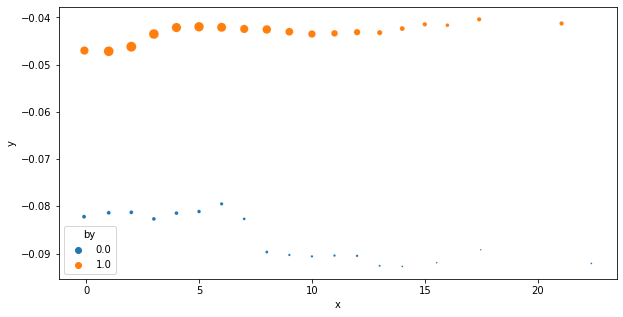

In [26]:
from src.dmlutils import binscatter
fig, ax = plt.subplots(1,1, figsize=(10, 5))

# toplot = binscatter(y=pd.DataFrame(cates), x=X[['car_age']], nbins=50)
# sns.scatterplot(data=toplot, x='x', y='y', s=100*toplot['count']/toplot['count'].max(), ax=ax)

toplot = binscatter(y=pd.DataFrame(cates), x=X[['car_age']], by=X['splmU55'], nbins=50)
sns.scatterplot(data=toplot, x='x', y='y', hue='by', s=100*toplot['count']/toplot['count'].max(), ax=ax)

plt.show()

In [27]:
hm = (
    pd.concat([pd.DataFrame(cates, columns=['cate'], index=X.index), X[['year', 'modelyr']]], axis=1)
    .groupby(['year', 'modelyr']).agg(['mean', 'count'])
    .reset_index()
)
hm.columns = ['year', 'modelyr', 'mean', 'count']

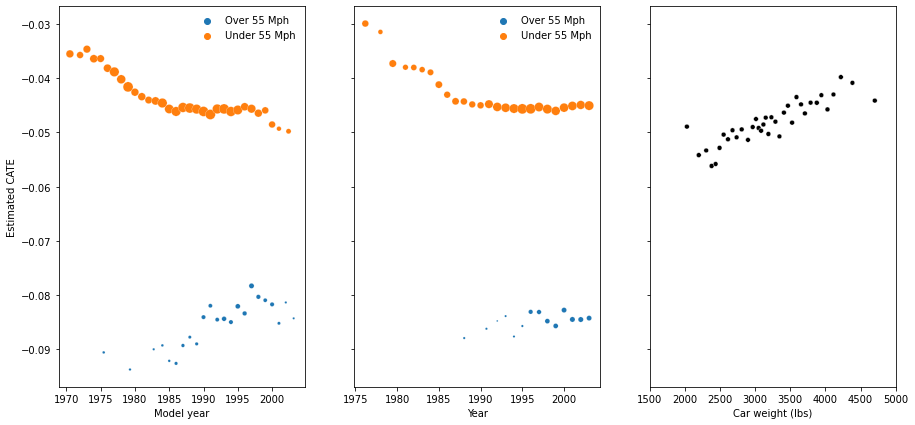

In [28]:
from src.dmlutils import binscatter
fig, ax = plt.subplots(1,3, figsize=(15, 7), sharex=False, sharey=True)

toplot = binscatter(y=pd.DataFrame(cates), x=X[['modelyr']], by=X['splmU55'], nbins=50)
sns.scatterplot(data=toplot, x='x', y='y', hue='by', s=100*toplot['count']/toplot['count'].max(), ax=ax[0])
ax[0].legend(handles= ax[0].legend_.legendHandles, labels = ['Over 55 Mph', 'Under 55 Mph'], frameon=False)
ax[0].set_ylabel('Estimated CATE')
ax[0].set_xlabel('Model year')

toplot = binscatter(y=pd.DataFrame(cates), x=X[['year']], by=X['splmU55'], nbins=50)
sns.scatterplot(data=toplot, x='x', y='y', hue='by', s=100*toplot['count']/toplot['count'].max(), ax=ax[1])
ax[1].legend(handles= ax[1].legend_.legendHandles, labels = ['Over 55 Mph', 'Under 55 Mph'], frameon=False)
ax[1].set_ylabel('Estimated CATE')
ax[1].set_xlabel('Year')

toplot = binscatter(y=pd.DataFrame(cates), x=X[['thoulbs_I']]*1000, nbins=50)
sns.scatterplot(data=toplot, x='x', y='y', s=300*toplot['count']/toplot['count'].max(), ax=ax[2], color='black')
# ax[1].set_ylabel('Estimated CATE')
ax[2].set_xlabel('Car weight (lbs)')
ax[2].set_xlim(1500,5000)

plt.show()

## Policy Learning

In [29]:
# from sklearn.linear_model import LinearRegression
# controls = [item for typ in ft.feat_type.values() for item in typ]

# results = []
# pipe = ft.construct_data_pipeline(pd_output=True)
# for feat in [col for col in controls if col in df_repl]: 
#     dt = pipe.fit_transform(df_repl[[feat]])
#     mdl = LinearRegression().fit(dt, y)
#     results.append([feat, r2_score(y, mdl.predict(dt))])
# ordered_features = pd.DataFrame(results, columns=['feature', 'r2']).sort_values('r2', ascending=False)['feature'].to_list()